In [12]:
from google.colab import drive

drive.mount('/content/drive')
base = "/content/drive/MyDrive/FIT5196Assignment2/" # for colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Begin here if running locally

# base = ""

In [14]:
# Load dataset
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import os
# from sklearn.preprocessing import PolynomialFeatures # For interaction terms, was not used in final run
# from itertools import product # For lambda grid search pruning, was not used in final run

INPUT_FILE = base + "suburb_info.xlsx"
FEATURES = ["number_of_houses", "number_of_units", "population", "aus_born_perc", "median_income"]
TARGET = "median_house_price"
LAMBDAS = [-1.0, -0.5, 0.0, 0.5, 1.0]
SCALERS = ["minmax", "robust", "zscore"]
CV_FOLDS = 3
RANDOM_STATE = 0

# Load
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Could not find {INPUT_FILE} in the working directory. Make sure the file is present.")

df = pd.read_excel(INPUT_FILE)

# --- Dataframe parsing ---
# Convert 'aus_born_perc' from '67%' → 67.0 (float)
df["aus_born_perc"] = df["aus_born_perc"].astype(str).str.replace('%', '', regex=False)
df["aus_born_perc"] = pd.to_numeric(df["aus_born_perc"], errors="coerce")

# Convert 'median_income' from '$1,583' → 1583 (int)
df["median_income"] = (
    df["median_income"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Convert 'median_house_price' from '$1,148,100' → 1148100 (int)
df["median_house_price"] = (
    df["median_house_price"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

# Check positives (Box-Cox requires > 0)
for col in FEATURES + [TARGET]:
    if (df[col] <= 0).any():
        raise ValueError(f"Column {col} contains non-positive values; Box-Cox requires strictly positive values.")

In [10]:
# --- Linear model grid search for best fit ---
# Prepare linear model to test best data transformations
X_orig = df[FEATURES].astype(float).copy()
y = df[TARGET].astype(float).copy()

results = []
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
model = LinearRegression()

# # --- Prune lambda combos by pearson coefficients (was found not helpful) ---
# candidate_lambdas = np.arange(-1, 1.5, 0.5)
# lambda_candidates = {}

# for col in FEATURES:
#     x = X_orig[col].values
#     best = []
#     for lam in candidate_lambdas:
#         try:
#             x_bc = stats.boxcox(x, lmbda=lam)
#             corr = abs(np.corrcoef(x_bc, y)[0, 1])
#             best.append((lam, corr))
#         except Exception:
#             continue
#     top_lams = sorted(best, key=lambda t: -t[1])[:3]
#     lambda_candidates[col] = [t[0] for t in top_lams]

# print(lambda_candidates)

# lambda_combos = list(product(
#     lambda_candidates["number_of_houses"],
#     lambda_candidates["number_of_units"],
#     lambda_candidates["population"],
#     lambda_candidates["aus_born_perc"],
#     lambda_candidates["median_income"]
# ))
# # --- End pruning ---

# Grid search on all lambda combos
lambda_combos = list(itertools.product(LAMBDAS, repeat=len(FEATURES)))
total_runs = len(SCALERS) * len(lambda_combos)
print(f"Total runs to evaluate: {total_runs}")

for scaler_name in SCALERS:
    for lambdas in lambda_combos:
        # Box-Cox transform each feature with its lambda
        X_trans = np.zeros_like(X_orig.values, dtype=float)
        for i, col in enumerate(FEATURES):
            lam = lambdas[i]
            X_trans[:, i] = stats.boxcox(X_orig.iloc[:, i].values, lmbda=lam)

        # Scale
        if scaler_name == "minmax":
            scaler = MinMaxScaler(feature_range=(0, 1))
        elif scaler_name == "robust":
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_trans)
        # # --- Add interaction terms (not used, worse performance) ---
        # poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
        # X_interact = poly.fit_transform(X_scaled)

        # CV
        r2_scores = cross_val_score(model, X_scaled, y.values, cv=kf, scoring="r2")
        neg_mse_scores = cross_val_score(model, X_scaled, y.values, cv=kf, scoring="neg_mean_squared_error")
        mse_scores = -neg_mse_scores
        rmse_scores = np.sqrt(mse_scores)

        results.append({
            "scaler": scaler_name,
            "lambdas": tuple(lambdas),
            "mean_R2": float(np.mean(r2_scores)),
            "std_R2": float(np.std(r2_scores)),
            "mean_RMSE": float(np.mean(rmse_scores)),
            "std_RMSE": float(np.std(rmse_scores))
        })

res_df = pd.DataFrame(results).sort_values(by="mean_R2", ascending=False).reset_index(drop=True)
out_path = "boxcox_scaling_results.csv"
# res_df.to_csv(out_path, index=False) # Save analysis results in csv for later comparison

print("Best result (by mean R^2):")
best = res_df.iloc[0]
print(f"  scaler: {best['scaler']}")
print(f"  lambdas (per feature order {FEATURES}): {best['lambdas']}")
print(f"  mean R^2: {best['mean_R2']:.6f} (std {best['std_R2']:.6f})")
print(f"  mean RMSE: {best['mean_RMSE']:.6f} (std {best['std_RMSE']:.6f})")
# print(f"All results saved to: {out_path}")


Total runs to evaluate: 9375
Best result (by mean R^2):
  scaler: robust
  lambdas (per feature order ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']): (0.5, 0.0, -0.5, -1.0, 1.0)
  mean R^2: 0.674475 (std 0.073214)
  mean RMSE: 267153.600107 (std 36083.937597)


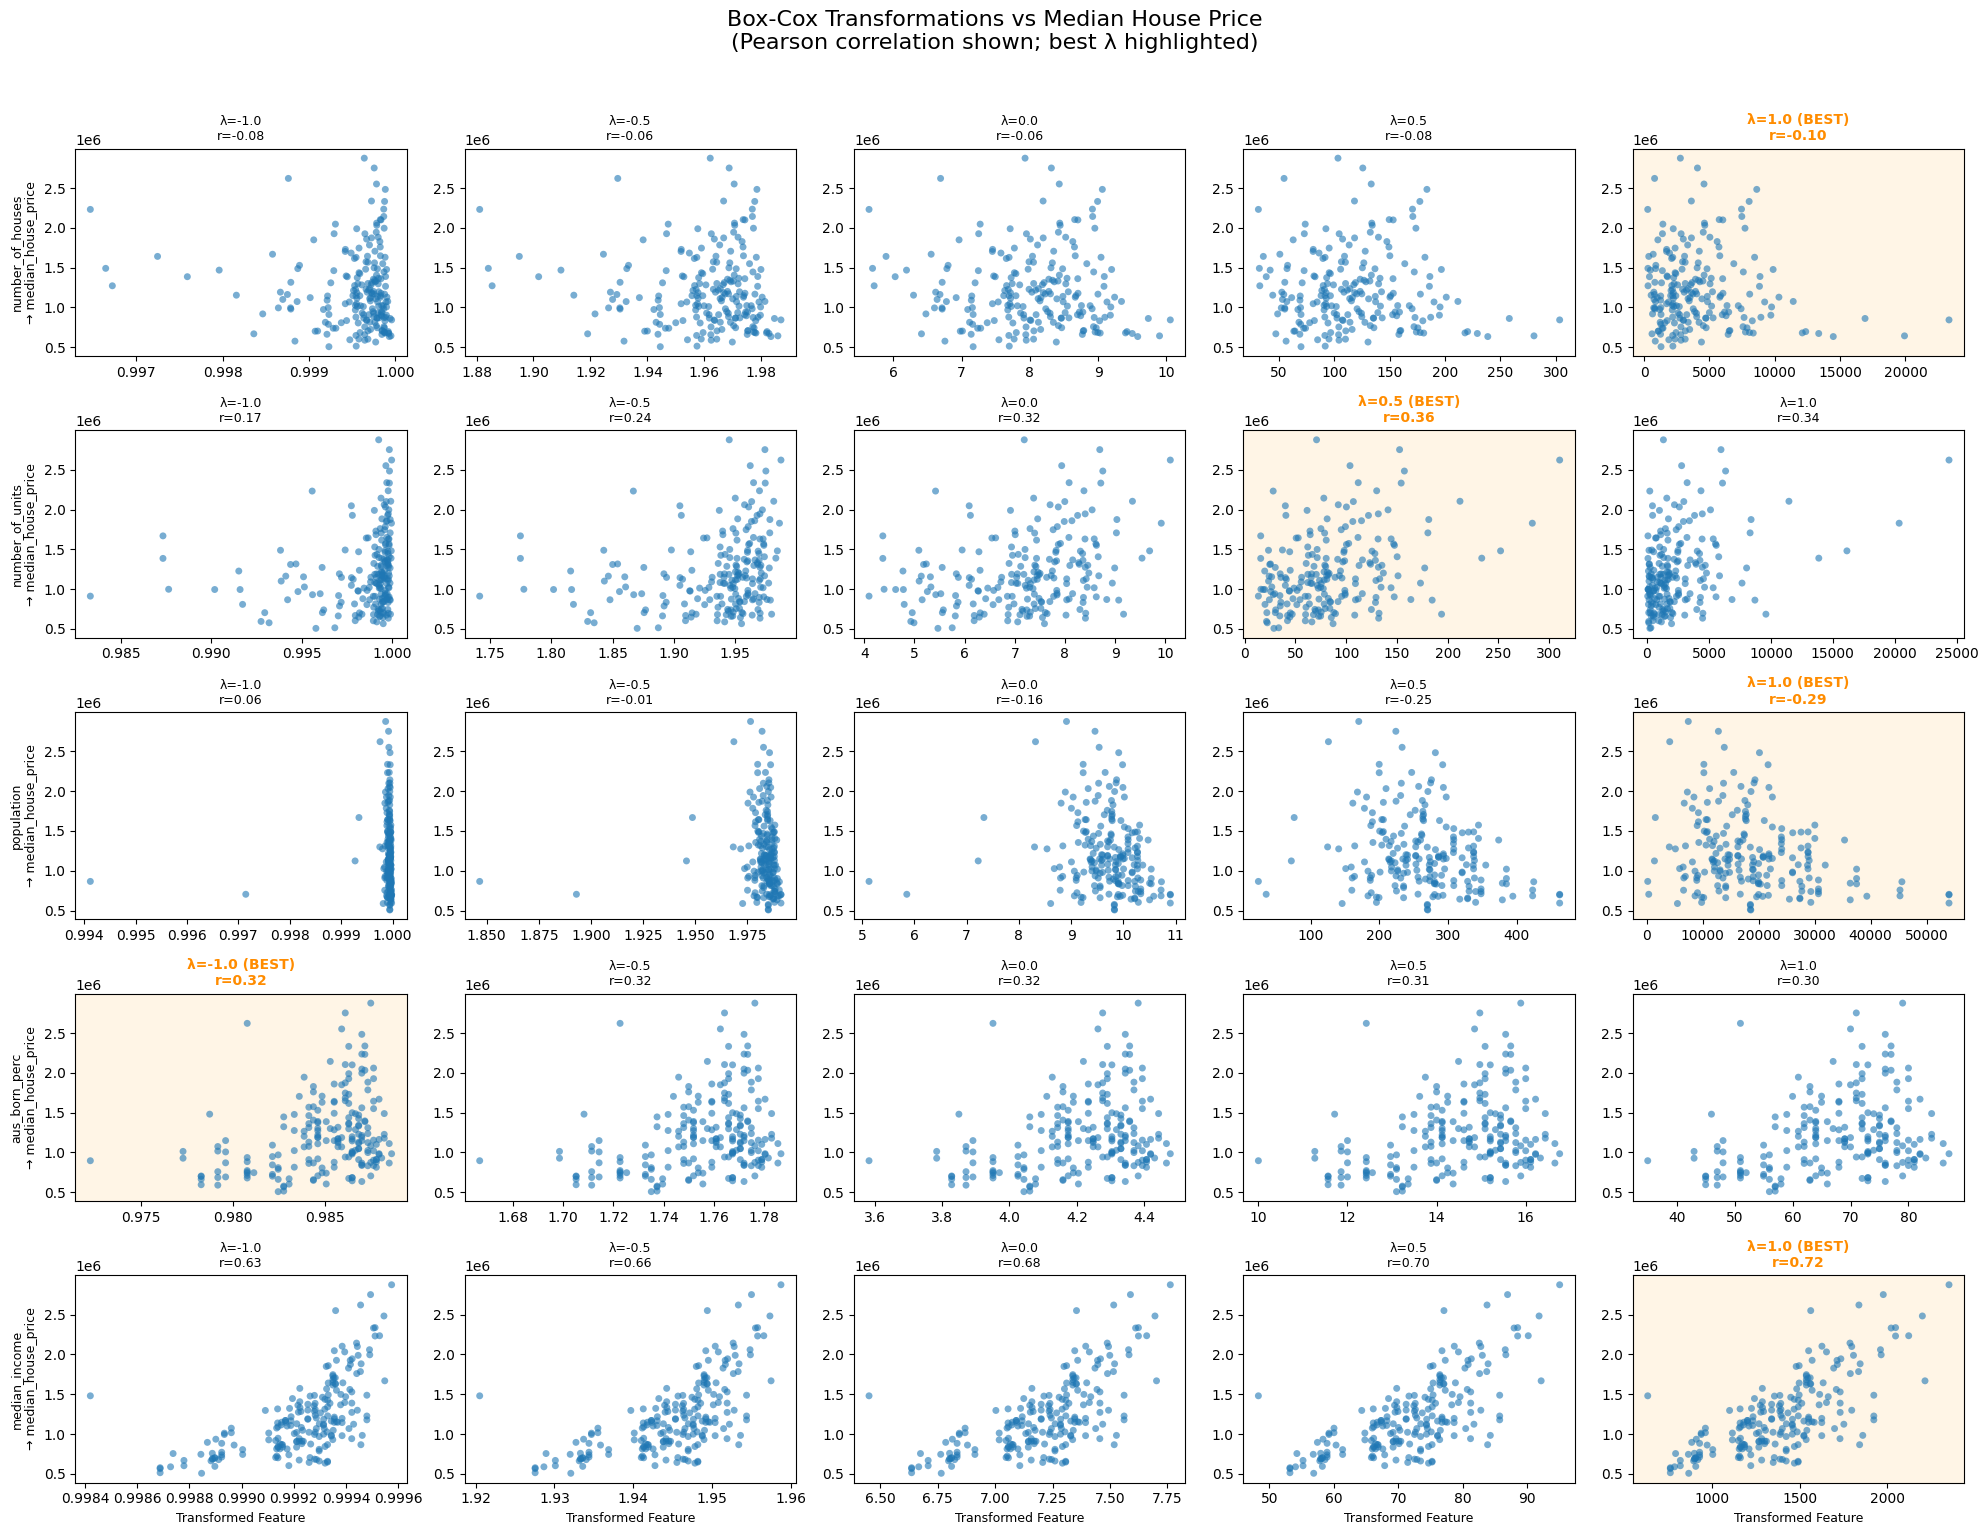

=== Best λ per feature (by |Pearson r| with median_house_price) ===
         feature  best_lambda  best_abs_corr
   median_income          1.0       0.719384
 number_of_units          0.5       0.355216
   aus_born_perc         -1.0       0.320922
      population          1.0       0.287242
number_of_houses          1.0       0.104490


In [11]:
# === COMPUTE BOX–COX TRANSFORMS AND CORRELATIONS FOR COMPARISON ANALYSIS ===
import matplotlib.pyplot as plt

corr_map = {}  # store best correlation info
transformations = {}
y = df[TARGET].values
for col in FEATURES:
    x = df[col].values
    corr_list = []
    x_transformed = []
    for lam in LAMBDAS:
        try:
            x_bc = stats.boxcox(x, lmbda=lam)
            r, _ = stats.pearsonr(x_bc, y)
        except Exception:
            x_bc = np.full_like(x, np.nan)
            r = np.nan
        corr_list.append(r)
        x_transformed.append(x_bc)
    corr_map[col] = {
        "best_lambda": LAMBDAS[np.nanargmax(np.abs(corr_list))],
        "best_r": np.nanmax(np.abs(corr_list)),
        "r_values": corr_list
    }
    transformations[col] = x_transformed

# === PLOT ===
fig, axes = plt.subplots(len(FEATURES), len(LAMBDAS),
                         figsize=(20, 15), sharey=False)
fig.suptitle("Box-Cox Transformations vs Median House Price\n(Pearson correlation shown; best λ highlighted)",
             fontsize=16, y=1.02)

for i, col in enumerate(FEATURES):
    best_lam = corr_map[col]["best_lambda"]
    best_r = corr_map[col]["best_r"]

    for j, lam in enumerate(LAMBDAS):
        x_bc = transformations[col][j]
        r = corr_map[col]["r_values"][j]
        ax = axes[i, j]
        ax.scatter(x_bc, y, alpha=0.6, s=25, edgecolor='none')

        # highlight best λ with colored border / title
        if lam == best_lam:
            ax.set_facecolor("#fff5e6")  # light highlight background
            ax.set_title(f"λ={lam:.1f} (BEST)\nr={r:.2f}", fontsize=10, fontweight='bold', color='darkorange')
        else:
            ax.set_title(f"λ={lam:.1f}\nr={r:.2f}", fontsize=9)

        if j == 0:
            ax.set_ylabel(f"{col}\n→ {TARGET}", fontsize=9)
        if i == len(FEATURES) - 1:
            ax.set_xlabel("Transformed Feature", fontsize=9)

plt.tight_layout()
plt.show()

# === PRINT SUMMARY TABLE ===
summary = pd.DataFrame({
    "feature": FEATURES,
    "best_lambda": [corr_map[c]["best_lambda"] for c in FEATURES],
    "best_abs_corr": [corr_map[c]["best_r"] for c in FEATURES]
}).sort_values(by="best_abs_corr", ascending=False)

print("=== Best λ per feature (by |Pearson r| with median_house_price) ===")
print(summary.to_string(index=False))


# Evaluation of Data Transformation and Scaling Strategies for Linear Regression Performance

## Objective
The goal of this exploration was to determine how best to scale and transform five explanatory variables—  
`number_of_houses`, `number_of_units`, `population`, `aus_born_perc`, and `median_income`—  
to predict `median_house_price` using a linear regression model.

Because linear regression assumes approximately linear relationships and comparable feature magnitudes, we systematically tested multiple transformation and scaling approaches to identify the configuration that maximizes model performance.

---

## Methodology

### 1. Framework design
An automated evaluation framework was created that:
- Applies **Box–Cox power transformations** to each feature, using varying λ values.  
- Applies one of three **scaling methods** across all features:
  - **Min–Max scaling** to [0, 1]  
  - **Robust scaling** (median and IQR)  
  - **Standardization** (z-score: subtract mean, divide by standard deviation)  
- Fits a **linear regression model** to predict median house price.
- Evaluates performance using **3-fold cross-validated R²** and RMSE metrics.
- Exhaustively searches all permutations of λ choices and scaling methods.

This grid-search approach yields objective, quantitative comparisons across data-preparation strategies. The dataset’s modest size makes such exhaustive testing computationally feasible; if it were larger, we could instead subsample or use a randomized search.

---

### 2. Lambda pruning
Initially, we tested the feasibility of **pruning λ values** by inspecting the **Pearson correlation coefficients** between each transformed feature and the target.  
The idea was to discard transformations that showed weak univariate correlation, thereby reducing computational load.

While this pruning drastically reduced runtime, it did **not reproduce the same best-performing results** as the full grid search.  
We therefore retained the full λ search in the final evaluation.

---

### 3. Lambda range expansion
We also extended the λ search range from **[−1, 1]** to **[−5, 5]**.  
However, when pruning was used within this broader range, the best performance actually **deteriorated**, suggesting that extreme Box–Cox powers distorted feature relationships rather than improving linearity.  
Consequently, we reverted to the [−1, 1] range.

---

### 4. Scaling comparison
Across all tested configurations, the choice of scaling method—Min–Max, Robust, or Standardization—had **minimal influence** on the final R² scores.  
This indicates that the model is not strongly sensitive to scaling once all features are on comparable numeric ranges.

---

### 5. Interaction terms
We then tested a model including **pairwise interaction terms** between all features, allowing potential cross-correlations to contribute to model fit.  
Contrary to expectations, the interaction model produced a **slightly lower best R²** (0.67041) compared with the simpler additive model (0.67447).  
This suggests that interaction effects did not generalize well and may have introduced mild overfitting or redundancy among correlated predictors.

---

## Results Summary

| Model Type | Best λ Combination (for features: houses, units, population, aus_born_perc, median_income) | Scaling | Best CV R² | Notes |
|-------------|-------------------------------------------------------------------------------------------|----------|-------------|-------|
| Simple linear regression | (0.5, 0.0, −0.5, −1.0, 1.0) | Any (insensitive) | **0.67447** | Best overall |
| Linear regression with interaction terms | (0.5, 0.0, 1.0, −0.5, 1.0) | Any | 0.67041 | Slightly worse |
| Correlation-optimized (by Pearson r) | (1.0, 0.5, 1.0, −1.0, 1.0) | Any | 0.65764 | Sub-optimal |

Baseline (no transformations): **R² = 0.61420**  
→ Transformation improved explanatory power modestly (+0.06 R²), but not dramatically.

---

## Diagnostic insights
Visual inspection of **Box–Cox transformation plots** and **Pearson correlations** revealed that:
- Some features (e.g., `median_income`, `number_of_units`) already exhibited near-linear relationships with price.  
- Others (e.g., `population`, `aus_born_perc`) benefited modestly from non-linear transformations.  
- However, the λ combination that individually maximized feature–target correlations did **not** coincide with the globally best model configuration.

This confirmed that **individual feature linearity does not guarantee collective model optimality**, since transformations interact and affect multicollinearity within the regression.

---

## Conclusions and Recommendations

1. **Select transformations based on overall model R², not individual feature correlation.**  
   The linear model’s performance depends on the joint behavior of all predictors, not just their pairwise associations with the target.

2. **Box–Cox transformations provide moderate improvement**, raising R² from 0.61 → 0.67.  
   The effect is consistent but not dramatic, suggesting that the raw relationships were already fairly linear.

3. **Scaling choice is not critical** once all variables are numeric and on comparable magnitudes.

4. **Avoid interaction terms** in this context.  
   They did not yield meaningful gains and slightly reduced cross-validated performance.

5. **Pruning by Pearson r or using extreme λ ranges** should be avoided—both simplified computation but compromised accuracy.

---

## Final Recommendation
For this dataset, the **best preparation for linear regression** is:
- Apply **Box–Cox transformation** with λ = (0.5, 0.0, −0.5, −1.0, 1.0) respectively for  
  `number_of_houses`, `number_of_units`, `population`, `aus_born_perc`, and `median_income`.

  These correspond to the following approximate transformations:
  - λ = 0.5 → square-root transform of `number_of_houses`
  - λ = 0.0 → natural log transform of `number_of_units`
  - λ = −0.5 → reciprocal square-root transform of `population`
  - λ = −1.0 → reciprocal transform of `aus_born_perc`
  - λ = 1.0 → no transform (retain original scale) for `median_income`  
- Use **any consistent scaling method** (z-score standardization recommended for interpretability).  
- Fit a **simple linear regression model** without interaction terms.  

This combination yielded the highest cross-validated R² = **0.67447**, representing the optimal balance between transformation complexity and model interpretability.


Prompt used:  
https://chatgpt.com/share/68f5a6d7-9e08-8005-b660-0899d6500b73